In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [20]:
# Exploring MIMIC dataset
mimic = pd.read_csv("./bsc_project_set.csv")

In [21]:
# Drop 'Unnamed: 0' column and make categorical into numerical
mimic = mimic.drop(columns=['Unnamed: 0'], axis=1)
mimic['sex'].replace(['F', 'M'], [0, 1], inplace=True)
mimic['peep_regime'].replace(['low', 'high'],[0, 1], inplace=True)
mimic['mort_28'].replace([False, True], [0, 1], inplace=True)

In [22]:
mimic.head(10)

,id,mort_28,age,sex,weight,height,pf_ratio,po2,pco2,ph,...,fio2,hco3,heart_rate,minute_volume,peep,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure,peep_regime
0,32128372,0,75,0,93.0,168.0,241.944444,130.666667,28.111111,7.245556,...,50.000000,12.000000,115.408163,8.241111,8.777778,24.333333,18.943662,100.600000,68.200000,0
1,34100191,0,47,1,127.0,183.0,166.356061,113.076923,34.461538,7.196923,...,68.500000,12.750000,115.407407,16.628571,7.375000,17.500000,19.857143,99.000000,68.000000,0
2,38292466,0,85,1,77.5,170.0,224.000000,112.000000,38.000000,7.440000,...,51.818182,23.000000,70.041667,9.433333,5.000000,22.333333,15.833333,102.000000,46.333333,0
3,32743332,0,85,1,90.7,170.0,205.714286,72.000000,38.000000,7.500000,...,36.875000,27.000000,70.480000,7.478571,5.000000,24.000000,18.200000,108.083333,46.208333,0
4,35009126,1,64,1,70.0,183.0,173.777778,94.666667,38.666667,7.400000,...,52.500000,21.666667,73.955556,7.050000,5.428571,14.328571,15.016667,103.415094,57.377358,0
5,38740124,0,38,1,84.1,178.0,345.000000,199.000000,44.000000,7.410000,...,60.000000,25.500000,102.909091,7.725000,5.750000,NaN,16.230769,126.181818,78.909091,0
6,32359580,1,69,1,86.2,185.0,354.723810,213.500000,32.000000,7.107000,...,66.250000,9.888889,93.500000,10.500000,8.333333,25.500000,23.852941,91.000000,56.363636,0
7,39880770,0,28,0,120.0,170.0,770.000000,308.000000,35.000000,7.340000,...,51.111111,25.000000,95.193548,7.842857,5.625000,15.000000,19.526316,112.620690,51.206897,0
8,37153661,1,82,0,46.3,157.0,140.071429,109.000000,36.000000,7.340000,...,60.000000,17.500000,96.090909,7.962500,6.250000,19.000000,21.292683,100.000000,46.235294,0
9,33630048,0,70,0,63.7,157.0,310.000000,126.000000,29.666667,7.356667,...,50.000000,16.000000,70.720000,6.516667,5.000000,16.500000,16.451613,100.705882,54.470588,0


In [23]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

# Perform iterative imputation
def imputeIterative(X):
    X_no_id = X.drop(columns=['id'], axis=1)
    impute = IterativeImputer(random_state=0, max_iter=20)
    impute.fit(X_no_id)
    imputed_X = impute.transform(X_no_id)
    imputed_DF = pd.DataFrame(imputed_X, columns=X_no_id.columns)
    imputed_DF.insert(0, 'id', X['id'].values)
    return imputed_DF

In [24]:
from sklearn.impute import KNNImputer

# Perform KNNImputer imputation
def imputeKNN(X, n_neighbors):  
    X_no_id = X.drop(columns=['id'], axis=1)
    impute = KNNImputer(n_neighbors=n_neighbors)
    impute.fit(X_no_id)
    imputed_X = impute.transform(X_no_id)
    impute_DF = pd.DataFrame(imputed_X, columns=X_no_id.columns)
    impute_DF.insert(0, 'id', X['id'].values)
    return impute_DF

In [25]:
# Removing all rows containing at least one NaN
filtered_mimic = mimic.dropna()
original_iterative = imputeIterative(filtered_mimic)
original_knn = imputeKNN(filtered_mimic, 4)

In [26]:
# Comparing different imputation techniques
def impute_nans(df, exclude_columns, nan_fraction=0.35):
    df_nan = df.copy()
    nan_indices = []
    total_values = df.size
    n_nans = int(total_values * nan_fraction)
    
    exclude_indices = []
    if exclude_columns:
        for col in exclude_columns:
            exclude_indices.append(df.columns.get_loc(col))
    
    valid_positions = [pos for pos in range(total_values) if divmod(pos, df.shape[1])[1] not in exclude_indices]
    nan_positions = np.random.choice(valid_positions, n_nans, replace=False)

    for pos in nan_positions:
        row, col = divmod(pos, df.shape[1])
        df_nan.iat[row, col] = np.nan
        nan_indices.append((row, df.columns[col]))
    
    return df_nan, nan_indices

exclude_col = ['id', 'mort_28', 'age', 'sex', 'heart_rate', 'respiratory_rate', 'peep_regime']
df_nan, nan_indices = impute_nans(filtered_mimic, exclude_col)

In [27]:
impute_iterative = imputeIterative(df_nan)
imputeKNN_2 = imputeKNN(df_nan, 2)
imputeKNN_6 = imputeKNN(df_nan, 6)
imputeKNN_12 = imputeKNN(df_nan, 12)

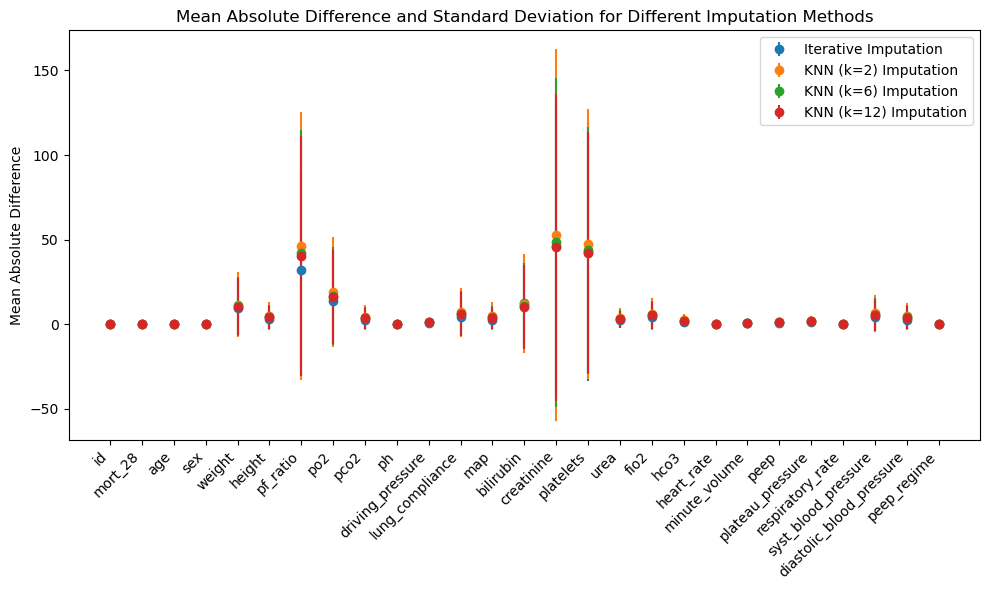

In [28]:
# Find mean + standard dev of the difference between the original data and the imputed data
mean_iterative = np.abs(impute_iterative - original_iterative).mean(axis=0)
mean_knn_2 = np.abs(imputeKNN_2 - original_knn).mean(axis=0)
mean_knn_6 = np.abs(imputeKNN_6 - original_knn).mean(axis=0)
mean_knn_12 = np.abs(imputeKNN_12 - original_knn).mean(axis=0)

std_iterative = np.abs(impute_iterative - original_iterative).std(axis=0)
std_knn_2 = np.abs(imputeKNN_2 - original_knn).std(axis=0)
std_knn_6 = np.abs(imputeKNN_6 - original_knn).std(axis=0)
std_knn_12 = np.abs(imputeKNN_12 - original_knn).std(axis=0)

# Plotting results in one graph
features = np.array(impute_iterative.columns)
x = range(len(features))

plt.figure(figsize=(10, 6))
plt.errorbar(x, mean_iterative, yerr=std_iterative, fmt='o', label='Iterative Imputation')
plt.errorbar(x, mean_knn_2, yerr=std_knn_2, fmt='o', label='KNN (k=2) Imputation')
plt.errorbar(x, mean_knn_6, yerr=std_knn_6, fmt='o', label='KNN (k=6) Imputation')
plt.errorbar(x, mean_knn_12, yerr=std_knn_12, fmt='o', label='KNN (k=12) Imputation')

# Set plot labels and title
plt.ylabel('Mean Absolute Difference')
plt.xticks(x, features, rotation=45, ha='right')
plt.title('Mean Absolute Difference and Standard Deviation for Different Imputation Methods')

plt.legend()
plt.tight_layout()
plt.show()

In [29]:
mean_iterative = mean_iterative.tolist()
mean_knn_2 = mean_knn_2.tolist()
mean_knn_6 = mean_knn_6.tolist()
mean_knn_12 = mean_knn_12.tolist()

std_iterative = std_iterative.tolist()
std_knn_2 = std_knn_2.tolist()
std_knn_6 = std_knn_6.tolist()
std_knn_12 = std_knn_12.tolist()

In [30]:
mean_values = np.vstack([mean_iterative, mean_knn_2, mean_knn_6, mean_knn_12])
std_values = np.vstack([std_iterative, std_knn_2, std_knn_6, std_knn_12])

# Identify which method performs best (has lowest difference)
best_mean = np.argmin(mean_values, axis=0)
best_std = np.argmin(std_values, axis=0)

best_mean_counts = np.bincount(best_mean, minlength=4)
best_std_counts = np.bincount(best_std, minlength=4)

# Results
methods = ['Iterative Imputation', 'KNN Imputation, k=2', 'KNN Imputation, k=6', 'KNN Imputation, k=12']
print("Best performance in mean absolute difference:")
for i, count in enumerate(best_mean_counts):
    print(f"{methods[i]}: {count} features")

print("\nBest performance in std:")
for i, count in enumerate(best_std_counts):
    print(f"{methods[i]}: {count} features")

Best performance in mean absolute difference:
Iterative Imputation: 24 features
KNN Imputation, k=2: 0 features
KNN Imputation, k=6: 0 features
KNN Imputation, k=12: 3 features

Best performance in std:
Iterative Imputation: 25 features
KNN Imputation, k=2: 0 features
KNN Imputation, k=6: 0 features
KNN Imputation, k=12: 2 features


In [31]:
# Since Iterative Imputation performs best, we will use this method to impute missing values in the MIMIC dataset
impute_mimic = imputeIterative(mimic)
impute_mimic.to_csv('impute_mimic.csv')

In [32]:
mimic.head(10)

,id,mort_28,age,sex,weight,height,pf_ratio,po2,pco2,ph,...,fio2,hco3,heart_rate,minute_volume,peep,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure,peep_regime
0,32128372,0,75,0,93.0,168.0,241.944444,130.666667,28.111111,7.245556,...,50.000000,12.000000,115.408163,8.241111,8.777778,24.333333,18.943662,100.600000,68.200000,0
1,34100191,0,47,1,127.0,183.0,166.356061,113.076923,34.461538,7.196923,...,68.500000,12.750000,115.407407,16.628571,7.375000,17.500000,19.857143,99.000000,68.000000,0
2,38292466,0,85,1,77.5,170.0,224.000000,112.000000,38.000000,7.440000,...,51.818182,23.000000,70.041667,9.433333,5.000000,22.333333,15.833333,102.000000,46.333333,0
3,32743332,0,85,1,90.7,170.0,205.714286,72.000000,38.000000,7.500000,...,36.875000,27.000000,70.480000,7.478571,5.000000,24.000000,18.200000,108.083333,46.208333,0
4,35009126,1,64,1,70.0,183.0,173.777778,94.666667,38.666667,7.400000,...,52.500000,21.666667,73.955556,7.050000,5.428571,14.328571,15.016667,103.415094,57.377358,0
5,38740124,0,38,1,84.1,178.0,345.000000,199.000000,44.000000,7.410000,...,60.000000,25.500000,102.909091,7.725000,5.750000,NaN,16.230769,126.181818,78.909091,0
6,32359580,1,69,1,86.2,185.0,354.723810,213.500000,32.000000,7.107000,...,66.250000,9.888889,93.500000,10.500000,8.333333,25.500000,23.852941,91.000000,56.363636,0
7,39880770,0,28,0,120.0,170.0,770.000000,308.000000,35.000000,7.340000,...,51.111111,25.000000,95.193548,7.842857,5.625000,15.000000,19.526316,112.620690,51.206897,0
8,37153661,1,82,0,46.3,157.0,140.071429,109.000000,36.000000,7.340000,...,60.000000,17.500000,96.090909,7.962500,6.250000,19.000000,21.292683,100.000000,46.235294,0
9,33630048,0,70,0,63.7,157.0,310.000000,126.000000,29.666667,7.356667,...,50.000000,16.000000,70.720000,6.516667,5.000000,16.500000,16.451613,100.705882,54.470588,0


In [33]:
impute_mimic.head(10)

,id,mort_28,age,sex,weight,height,pf_ratio,po2,pco2,ph,...,fio2,hco3,heart_rate,minute_volume,peep,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure,peep_regime
0,32128372,0.0,75.0,0.0,93.0,168.0,241.944444,130.666667,28.111111,7.245556,...,50.000000,12.000000,115.408163,8.241111,8.777778,24.333333,18.943662,100.600000,68.200000,0.0
1,34100191,0.0,47.0,1.0,127.0,183.0,166.356061,113.076923,34.461538,7.196923,...,68.500000,12.750000,115.407407,16.628571,7.375000,17.500000,19.857143,99.000000,68.000000,0.0
2,38292466,0.0,85.0,1.0,77.5,170.0,224.000000,112.000000,38.000000,7.440000,...,51.818182,23.000000,70.041667,9.433333,5.000000,22.333333,15.833333,102.000000,46.333333,0.0
3,32743332,0.0,85.0,1.0,90.7,170.0,205.714286,72.000000,38.000000,7.500000,...,36.875000,27.000000,70.480000,7.478571,5.000000,24.000000,18.200000,108.083333,46.208333,0.0
4,35009126,1.0,64.0,1.0,70.0,183.0,173.777778,94.666667,38.666667,7.400000,...,52.500000,21.666667,73.955556,7.050000,5.428571,14.328571,15.016667,103.415094,57.377358,0.0
5,38740124,0.0,38.0,1.0,84.1,178.0,345.000000,199.000000,44.000000,7.410000,...,60.000000,25.500000,102.909091,7.725000,5.750000,18.275128,16.230769,126.181818,78.909091,0.0
6,32359580,1.0,69.0,1.0,86.2,185.0,354.723810,213.500000,32.000000,7.107000,...,66.250000,9.888889,93.500000,10.500000,8.333333,25.500000,23.852941,91.000000,56.363636,0.0
7,39880770,0.0,28.0,0.0,120.0,170.0,770.000000,308.000000,35.000000,7.340000,...,51.111111,25.000000,95.193548,7.842857,5.625000,15.000000,19.526316,112.620690,51.206897,0.0
8,37153661,1.0,82.0,0.0,46.3,157.0,140.071429,109.000000,36.000000,7.340000,...,60.000000,17.500000,96.090909,7.962500,6.250000,19.000000,21.292683,100.000000,46.235294,0.0
9,33630048,0.0,70.0,0.0,63.7,157.0,310.000000,126.000000,29.666667,7.356667,...,50.000000,16.000000,70.720000,6.516667,5.000000,16.500000,16.451613,100.705882,54.470588,0.0


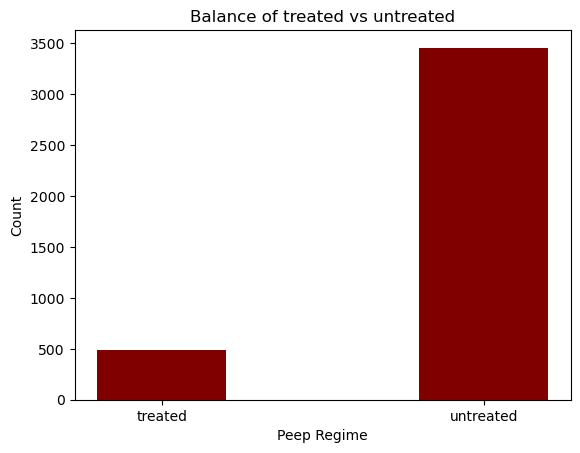

In [34]:
# Balance of treated vs untreated
peep_reg = impute_mimic['peep_regime'].tolist()
num_treated = peep_reg.count(1)
num_untreated = peep_reg.count(0)

x = ['treated', 'untreated']
y = [num_treated, num_untreated]
plt.bar(x, y, color ='maroon', width = 0.4)
plt.xlabel("Peep Regime")
plt.ylabel("Count")
plt.title("Balance of treated vs untreated")
plt.show()

In [35]:
print(num_treated)
print(num_untreated)

print(num_treated/(num_treated+num_untreated))

485
3456
0.12306521187515859
